In [1]:
#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [2]:
#@title Installs
!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow==2.15.0 --quiet #15 13
!pip install tf_keras==2.15.0 --quiet
!pip install tensorflow-datasets==4.8 --quiet #8
!pip install tensorflow-text==2.15.0 --quiet #15
!pip install transformers==4.17 --quiet #4.40.2 #4.37.2
!pip install pyyaml h5py

In [3]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import transformers

from tensorflow.keras.optimizers import Adam
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification


from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaModel

from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

In [4]:
#@title Global tunable parameters

# Sequence length to truncate/pad
MAX_SEQUENCE_LENGTH = 512

# hidden layer size after BERT's ouput
HIDDEN_LAYER_SIZE = 512

# Utility library

In [5]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('transformers')
print_version('tensorflow')
print_version('keras')
print_version('pandas')
print_version('sklearn')

numpy version: 1.25.2
transformers version: 4.17.0
tensorflow version: 2.15.0
keras version: 2.15.0
pandas version: 2.0.3
sklearn version: 1.2.2


In [6]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

# Dataset preparation

In [7]:
#@title Read Reddit dataset into a dataframe
rdt_trainfile = '/content/drive/MyDrive/MIDS-266/w266/project/Reddit/both_train.csv'
rdt_tesstfile = '/content/drive/MyDrive/MIDS-266/w266/project/Reddit/both_test.csv'
rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)

# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)


# Split data into test and train
train_size = int(0.8 * len(rdt_train))
X_train = rdt_train[0:train_size].post
X_val = rdt_train[train_size:].post
X_test = rdt_test.post
y_train = rdt_train[0:train_size].class_id
y_val = rdt_train[train_size:].class_id
y_test = rdt_test.class_id

train_labels = np.array(y_train)
test_labels = np.array(y_test)
val_labels = np.array(y_val)

train_examples_list = []
test_examples_list = []
val_examples_list = []

temp_train_examples = np.array(X_train)
temp_test_examples = np.array(X_test)
temp_val_examples = np.array(X_val)

for i in range(len(temp_train_examples)):
  size = len(temp_train_examples[i])
  lower = int(0.3*MAX_SEQUENCE_LENGTH)
  upper = int(0.7*MAX_SEQUENCE_LENGTH)
  if size > MAX_SEQUENCE_LENGTH:
    train_examples_list.append(temp_train_examples[i][:lower] + temp_train_examples[i][upper:])
  else:
    train_examples_list.append(temp_train_examples[i])

for i in range(len(temp_test_examples)):
  size = len(temp_test_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    test_examples_list.append(temp_test_examples[i][:lower] + temp_test_examples[i][upper:])
  else:
    test_examples_list.append(temp_test_examples[i])

for i in range(len(temp_val_examples)):
  size = len(temp_val_examples[i])
  lower = int(0.3*size)
  upper = int(0.7*size)
  if size > MAX_SEQUENCE_LENGTH:
    val_examples_list.append(temp_val_examples[i][:lower] + temp_val_examples[i][upper:])
  else:
    val_examples_list.append(temp_val_examples[i])

train_examples = np.array(train_examples_list)
test_examples = np.array(test_examples_list)
val_examples = np.array(val_examples_list)


In [8]:
print(rdt_train.class_name.unique())
rdt_train.class_id.unique()

['bipolar' 'depression' 'none' 'anxiety' 'adhd' 'ptsd']


array([2, 3, 5, 1, 0, 4])

In [9]:
rdt_train

,ID,title,post,class_name,class_id
0,cec40220-62b7-4d81-a8a1-4bb148ed0310,how do i deal with the aftermath of hypomania?,i cannot believe myself the past few weeks. sm...,bipolar,2
1,27ac6825-512c-4439-8f56-5424c6fc4e5b,anyone else just kind of existing?,"i wake up, go to work, come home, keep myself ...",depression,3
2,8605d928-8422-4cce-956b-b03b63a8654e,can you please point me in the direction of so...,hello! i'm working on predictive analytics rel...,none,5
3,e55afe17-1b4c-4e18-a905-6d56cbf70146,i hate myself and i hate that i hate myself an...,hi whoever reads this. i've deleted at least 6...,depression,3
4,c2f74eca-c631-4c0c-89ac-0fb175718e76,when i immediately get downvoted after pouring...,makes me think twice about ever sharing on thi...,depression,3
...,...,...,...,...,...
13722,d9b842d7-0bbc-43dc-919d-0f71989d69ba,i’m tired of getting ideas for things to do in...,does anyone else here experience this? i have ...,adhd,0
13723,cbf1bc7e-3b33-4231-88be-57f3d5e48fb7,why are some people so... mean :(,i could be having a fun time and then when one...,anxiety,1
13724,ddfe2ee8-998d-497e-bcaa-6d1012752ef5,panic attacks are back :(,‪3 days in a row with panic and several times ...,anxiety,1
13725,a65a1d78-dc36-4d6d-969f-a97a1a0356f4,the time between realization that you have adh...,"this is not a very good post, more of a rant.....",adhd,0


In [10]:
test_examples[30]

'this scene has played out what seems like hundreds of time pretty big paper due at midnight. the thought process throughout the day: 2:00 pm: i have loads of time, no sweat. 3:00 pm: as long as i leave myself a solid 6-8 hours to finish i\'ll be fine. 4:00 pm: i really should start working, but the sun is still up, i\'ll be fine. 5:00 pm: shit why am i wasting so much time?! i need to start asap, but first let me make some food. 6:00 pm: okay all full and ready to start. but first lets just browse reddit quick before i start. 7:00 pm: f*** its getting so late,ay great, just gonna check reddit quick before bed. its all lies but i keep falling for it. this probably sounds like good old fashion procrastination, but i give in to even the tiniest distraction because i believe all the bs my brain tells me. the entire day i\'m checking the clock and lying to myself. and this will happen for consecutive days. never do i say to myself, "hey you lets not do that again." instead i get "yeah yest

In [11]:
test_labels[30]

0

In [12]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Validation set labels shape: {val_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Validation set examples shape: {val_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

print('Distribution of the length of all posts')
print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (10981,)
Validation set labels shape: (2746,)
Test set labels shape: (1488,)
Training set examples shape: (10981,)
Validation set examples shape: (2746,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Distribution of the length of all posts
count    13727.000000
mean      1065.297734
std       1373.414370
min        123.000000
25%        362.000000
50%        658.000000
75%       1236.500000
max      38168.000000
Name: post, dtype: float64
Labels min : 0 max : 5


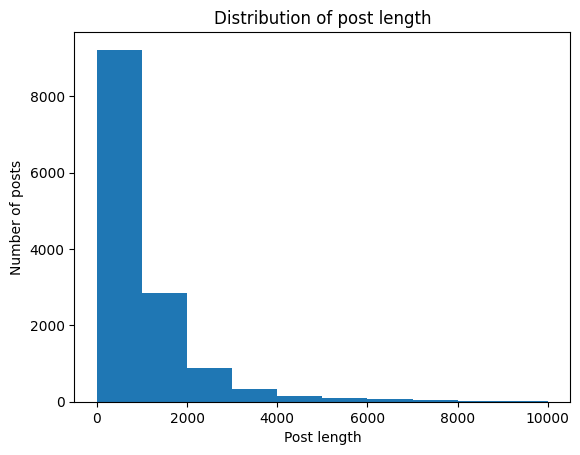

In [13]:
#@ Histogram of all post length
plt.hist(rdt_train["post"].str.len(), bins=10, range=(0, 10000))
plt.title('Distribution of post length')
plt.xlabel('Post length')
plt.ylabel('Number of posts')
plt.show()

In [14]:
#@title Distribution of labels in training and test sets
for i in range(np.max(train_labels)):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])/len(train_labels)
  print(f'Labels {i} in training set: {len(pos_indices[0])}/{len(train_labels)} ({pct_positive})')

for i in range(np.max(val_labels)):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])/len(val_labels)
  print(f'Labels {i} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive})')

for i in range(np.max(test_labels)):
  pos_indices = np.where(test_labels == i)
  pct_positive = len(pos_indices[0])/len(test_labels)
  print(f'Labels {i} in test set: {len(pos_indices[0])}/{len(test_labels)} ({pct_positive})')


Labels 0 in training set: 1967/10981 (0.17912758400874237)
Labels 1 in training set: 1946/10981 (0.17721518987341772)
Labels 2 in training set: 1928/10981 (0.1755759949002823)
Labels 3 in training set: 1960/10981 (0.17849011929696748)
Labels 4 in training set: 1602/10981 (0.145888352609052)
Labels 0 in validation set: 498/2746 (0.18135469774217042)
Labels 1 in validation set: 476/2746 (0.1733430444282593)
Labels 2 in validation set: 479/2746 (0.174435542607429)
Labels 3 in validation set: 490/2746 (0.17844136926438456)
Labels 4 in validation set: 399/2746 (0.1453022578295703)
Labels 0 in test set: 248/1488 (0.16666666666666666)
Labels 1 in test set: 248/1488 (0.16666666666666666)
Labels 2 in test set: 248/1488 (0.16666666666666666)
Labels 3 in test set: 248/1488 (0.16666666666666666)
Labels 4 in test set: 248/1488 (0.16666666666666666)


In [15]:
def tokenize(sentences, max_length=MAX_SEQUENCE_LENGTH, padding='max_length'):
    """Tokenize using the Huggingface tokenizer
    Args:
        sentences: String or list of string to tokenize
        padding: Padding method ['do_not_pad'|'longest'|'max_length']
    """
    return tokenizer(
        sentences,
        truncation=True,
        padding=padding,
        max_length=max_length,
        return_tensors="tf"
    )


In [16]:
def tokenize_data(tokenizer, input_str):
  tokenized = tokenizer(input_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
  return tokenized

In [17]:
#@title BERT Tokenization of training, validation and test data

def tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    bert_train_tokenized = tokenize_data(tokenizer, train_examples_str)
    bert_val_tokenized = tokenize_data(tokenizer, val_examples_str)

    bert_train_inputs = [bert_train_tokenized.input_ids,
                        bert_train_tokenized.token_type_ids,
                        bert_train_tokenized.attention_mask]


    bert_val_inputs = [bert_val_tokenized.input_ids,
                        bert_val_tokenized.token_type_ids,
                        bert_val_tokenized.attention_mask]


    return bert_train_inputs, bert_val_inputs

# BERT Model

In [18]:
#@title BERT Tokenization of training, validation and test data

def tokenize_test(tokenizer, test_examples):

    test_examples_str = [x for x in test_examples]

    # Tokenize training, validation and test data
    bert_test_tokenized = tokenize_data(tokenizer, test_examples_str)

    bert_test_inputs = [bert_test_tokenized.input_ids,
                        bert_test_tokenized.token_type_ids,
                        bert_test_tokenized.attention_mask]


    return bert_test_inputs

In [19]:

#@title Train BERT model using CLS token
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    bert_base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    # The first token of every example is a CLS token
    cls_embedding = bert_out[0][:, 0, :]
    print(cls_embedding.shape)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_embedding)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(6, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model


def bert_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train BERT model
    """
    # Load BERT model
    config_l = BertConfig.from_pretrained("bert-base-cased")
    config_l.num_max_position_embeddingslabels = 1024
    bert_model = TFBertModel.from_pretrained('bert-base-cased', config = config_l)

    # Load training, validation and test data
    train_samples = train[0:int(fraction*len(train))]
    val_samples = val[0:int(fraction*len(val))]

    # Tokenize training, validation and test data
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    bert_train_inputs, bert_val_inputs = tokenize_train_val(bert_tokenizer, train_samples, val_samples)

    # Convert labels to numpy arrays
    bert_train_labels = np.array(tlabels)
    bert_train_sample_labels = bert_train_labels[0:int(fraction*len(tlabels))]

    bert_val_labels = np.array(vlabels)
    bert_val_sample_labels = bert_val_labels[0:int(fraction*len(vlabels))]

    # Create classification model
    bert_avg_model = create_bert_cls_model(bert_model, hidden_size=HIDDEN_LAYER_SIZE)

    bert_avg_model.summary()

    bert_avg_model_history = bert_avg_model.fit(
        bert_train_inputs,
        bert_train_sample_labels,
        validation_data=(bert_val_inputs, bert_val_sample_labels),
        batch_size=12,
        epochs=2)

    return bert_avg_model, bert_avg_model_history

# Distilbert

In [20]:


def distilbert_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train distilbert model
    """

    LEARNING_RATE = 5e-5
    BATCH_SIZE = 16
    NUM_EPOCHS = 3

    NUM_LABELS = np.max(tlabels) + 1
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels= NUM_LABELS)

    # Load training, validation and test data
    tsamples = train[0:int(fraction*len(train))]
    train_samples = tsamples.tolist()
    vsamples = val[0:int(fraction*len(val))]
    val_samples = vsamples.tolist()

    # Convert labels to numpy arrays
    train_labels = np.array(tlabels)
    train_sample_labels = train_labels[0:int(fraction*len(tlabels))]

    val_labels = np.array(vlabels)
    val_sample_labels = val_labels[0:int(fraction*len(vlabels))]

    # Tokenize training, validation and test data
    distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(tokenize_data(distilbert_tokenizer, train_samples)),  # Convert BatchEncoding instance to dictionary
        train_sample_labels)).shuffle(1000).batch(BATCH_SIZE).prefetch(1)

    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(tokenize_data(distilbert_tokenizer, val_samples)),  # Convert BatchEncoding instance to dictionary
        val_sample_labels)).batch(BATCH_SIZE).prefetch(1)

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics='accuracy')

    model.summary()

    model_history = model.fit(
        train_dataset,
        y=None,
        validation_data=val_dataset,
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS)

    return model, model_history



# Roberta

In [21]:
#@title BERT Tokenization of training, validation and test data

def roberta_tokenize_train_val(tokenizer, train_examples, val_examples):

    train_examples_str = [x for x in train_examples]
    val_examples_str = [x for x in val_examples]

    # Tokenize training, validation and test data
    train_tokenized = tokenize_data(tokenizer, train_examples_str)
    val_tokenized = tokenize_data(tokenizer, val_examples_str)

    train_inputs = [train_tokenized.input_ids,
                        train_tokenized.attention_mask]


    val_inputs = [val_tokenized.input_ids,
                        val_tokenized.attention_mask]


    return train_inputs, val_inputs

In [35]:
#@title Train RoBERTa model - use CLS token
def create_roberta_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the CLS Token output for classification purposes.
    """

    bert_base_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)

    # The first token of every example is a CLS token
    cls_embedding = bert_out[0][:, 0, :]
    print(cls_embedding.shape)

    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_embedding)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    classification = tf.keras.layers.Dense(6, activation='softmax',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model




In [36]:
def roberta_main(train, val, tlabels, vlabels, fraction):
    """
    Main function to train RoBerta model
    """

    # Load training, validation and test data
    tsamples = train[0:int(fraction*len(train))]
    vsamples = val[0:int(fraction*len(val))]

    train_samples = tsamples
    val_samples = vsamples

    # Tokenize training, validation and test data
    roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    roberta_train_inputs, roberta_val_inputs = roberta_tokenize_train_val(roberta_tokenizer, train_samples, val_samples)

    # Convert labels to numpy arrays
    roberta_train_labels = np.array(tlabels)
    roberta_train_sample_labels = roberta_train_labels[0:int(fraction*len(tlabels))]

    roberta_val_labels = np.array(vlabels)
    roberta_val_sample_labels = roberta_val_labels[0:int(fraction*len(vlabels))]

    # Create classification model
    config_l = BertConfig.from_pretrained("roberta-base")
    config_l.num_max_position_embeddingslabels = 512

    roberta_model = TFRobertaModel.from_pretrained('roberta-base', config = config_l)
    roberta_classification_model = create_roberta_cls_model(roberta_model, hidden_size=HIDDEN_LAYER_SIZE)

    roberta_classification_model.summary()

    roberta_classification_model_history = roberta_classification_model.fit(
        roberta_train_inputs,
        roberta_train_sample_labels,
        validation_data=(roberta_val_inputs, roberta_val_sample_labels),
        batch_size=8,
        epochs=2
    )

    return roberta_classification_model, roberta_classification_model_history


# Main Control loop

In [37]:
def train(train_examples, val_examples, train_labels, val_labels, fraction, input_model):
  match input_model:
      case 1:
          model, model_history = bert_main(train_examples, val_examples, train_labels, val_labels, fraction)

      case 2:
          model, model_history = distilbert_main(train_examples, val_examples, train_labels, val_labels, fraction)

      case 3:
          model, model_history = roberta_main(train_examples, val_examples, train_labels, val_labels, fraction)

      case 4:
          roberta_attention_main()

      case _:
          print("Invalid input")

  # Save the model
  path = f'./saved_models/{input_model}/'
  if not os.path.exists(path):
    os.makedirs(path, exist_ok=True)
  tf.keras.models.save_model(model, path)
  #model.save(f'{path}/model.keras')

  return model, model_history

def predict(test_examples, test_labels, model_type, model):
  """
  Test the model on the test set
  """

  from sklearn.metrics import confusion_matrix

  #Predict
  match model_type:
      case 1:
        bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
        test_tokens = tokenize_test(bert_tokenizer, test_examples)
        y_prediction = model.predict(test_tokens)

      case 2:
        distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
        test_examples_list = test_examples.tolist()
        test_tokens = tokenize_data(distilbert_tokenizer, test_examples_list)
        y_prediction = model.predict((dict(test_tokens),)) # Pass a tuple to predict
        # Extract the NumPy array from the dictionary
        y_prediction = y_prediction[0] # Extract the NumPy array

      case 3:
        roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        test_examples_list = test_examples.tolist()
        test_tokens = tokenize_data(roberta_tokenizer, test_examples_list)
        y_prediction = model.predict((test_tokens['input_ids'], test_tokens['attention_mask']))

  # Convert predicted probabilities to class labels
  y_prediction = np.argmax(y_prediction, axis=1) # Convert probabilities to discrete class labels

  #Create confusion matrix and normalizes it over predicted (columns)
  result = confusion_matrix(test_labels, y_prediction , normalize='pred')
  print(result)

  return


def train_model():
  print('Enter the type of model to train: ')
  print('1. BERT with custom classifier')
  print('2. Distilbert')
  print('3. Roberta')
  print('4. Roberta with Attention')

  model_type = input()
  model_type = int(model_type)

  if model_type > 4:
    print('Invalid input')
    return

  print('Enter the fraction of the data to use: ')
  fraction = input()
  fraction = float(fraction)

  if fraction > 1:
    print('Invalid input')
    return

  model, model_history = train(train_examples, val_examples, \
                               train_labels, val_labels, \
                               fraction, model_type)

  return model, model_type, model_history

def load_my_model():

  print('Enter my custom saved modelbased of: ')
  print('1. BERT with custom classifier')
  print('2. Distilbert')
  print('3. Roberta')
  print('4. Roberta with Attention')
  model_type = input()
  model_type = int(model_type)

  if model_type > 4:
    print('Invalid input')
    return

  path = f'./saved_models/{model_type}/'
  if not os.path.exists(path):
    print('Model not found')
    return
  print(f'Loading model from {path}')
  lmodel = keras.models.load_model(path)

  return lmodel


# initialization
model_type = 0
model_history = None
model = None

if __name__ == '__main__':
  while True:
      print('Task selection menu')
      print('What task do you want to do [4]:')
      print('1. Load my fine tuned reddit posts model')
      print('2. Train (fine-tune) a base model')
      print('3. Run prediction on test dataset')
      print('4. Quit')

      task = input()
      task = int(task)

      if task >= 4:
        print(f'Invalid input {task}')
        break

      match(task):
        case 1:
          model = load_my_model()
          model.summary()

        case 2:
          model, model_type, model_history = train_model()

        case 3:
          if model is None or model_type == 0:
            print('Model not loaded')
            break
          predict(test_examples, test_labels, model_type, model)

        case _:
          print('Invalid input')
          break



Task selection menu
What task do you want to do [4]:
1. Load my fine tuned reddit posts model
2. Train (fine-tune) a base model
3. Run prediction on test dataset
4. Quit
2
Enter the type of model to train: 
1. BERT with custom classifier
2. Distilbert
3. Roberta
4. Roberta with Attention
3
Enter the fraction of the data to use: 
0.03


AttributeError: 'TFRobertaModel' object has no attribute 'bert'

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 512)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 512)]                0         []                            
 r)                                                                                               
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['attention_mask_layer[0][0]',
 aModel)                     ngAndCrossAttentions(last_   32         'input_ids_layer[0][0]'] 

In [26]:
#fig, axs = plt.subplots(2, 2)
#fig.subplots_adjust(left=0.2, wspace=0.6)
#make_plot(axs,
#          dan_shuffled_history,
#          wan_history,
#          model_1_name='dan',
#          model_2_name='wan')

#fig.align_ylabels(axs[:, 1])
#fig.set_size_inches(18.5, 10.5)
#plt.show()

In [29]:
!ls saved_models/3

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables
